
<p align="center">
    <img src="mosef.png" alt="MOSEF Logo" width="300">
</p>
```
</p>

<a href="https://linkedin.com/lucasvazelle">Vazelle Lucas, Tarverdian Mariam, Nguyen Nhi </a> $\cdot$ 2024-2025, MOSEF $\cdot$ 

---

Times series
- [Import données](https://cds.climate.copernicus.eu/datasets/sis-ocean-wave-timeseries?tab=overview)
- [Documentation Copernicus](https://confluence.ecmwf.int/display/CKB/Product+user+guide+for+sea+level+and+ocean+wave+products+-+time+series+and+indicators)


In [ ]:
!pip install xarray netcdf4 cartopy plotly statsmodels PyWavelets

ERROR: Could not find a version that satisfies the requirement pywt (from versions: none)
ERROR: No matching distribution found for pywt

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [99]:
!pip install pywt

ERROR: Could not find a version that satisfies the requirement pywt (from versions: none)
ERROR: No matching distribution found for pywt

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [138]:
import pandas as pd
import netCDF4 
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from statsmodels.tsa.seasonal import seasonal_decompose
import pywt
from statsmodels.tsa.stattools import adfuller
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf as sm_acf  # Correct import for acf


# Import donnée

In [ ]:
# import cdsapi

# dataset = "sis-ocean-wave-timeseries"
# request = {
#     "variable": [
#         "Mean wave direction",
#         "Mean wave period",
#         "Peak wave period",
#         "Significant wave height"
#     ],
#     "experiment": "ERA5 reanalysis",
#     "year": ["2016", "2017"]
# }

# client = cdsapi.Client()
# client.retrieve(dataset, request).download()


# Analyse exploratoire
Locs correspond aux corrdonnées de la station, il y en a près de 8000

station_x_coordinate station_y_coordinate correspondent aux coordonnées latitude et longitude des stations

mp1 (s) : période moyenne des vagues océaniques générées par les vents locaux et la houle. La période des vagues est le temps moyen nécessaire à deux crêtes de vagues consécutives, à la surface de l'océan/de la mer, pour passer par un point fixe

mwd (dégré) : direction moyenne des vagues de surface de l'océan/de la mer générées par les vents locaux et la houle.

pp1d (m) :  la période des vagues océaniques les plus énergétiques générées par les vents et la houle local

swh (m):  hauteur moyenne du tiers le plus élevé des vagues de surface de l'océan/de la mer générées par le vent et la houle. Il représente la distance verticale entre la crête et le creux de la vague. 

## Exploration préliminaire

In [3]:
data_folder = "data"
netcdf_files = [os.path.join(data_folder, f) for f in os.listdir(data_folder) if f.endswith(".nc")]

In [ ]:
import xarray as xr
ds = xr.open_dataset(netcdf_files[2])
ds


<xarray.Dataset> Size: 542MB
Dimensions:               (scalar: 1, time: 8784, locs: 7708)
Coordinates:
  * time                  (time) datetime64[ns] 70kB 2016-01-01 ... 2016-12-3...
    station_x_coordinate  (locs) float64 62kB ...
    station_y_coordinate  (locs) float64 62kB ...
Dimensions without coordinates: scalar, locs
Data variables:
    missing_value         (scalar) float64 8B ...
    mwd                   (time, locs) float64 542MB ...
Attributes: (12/18)
    title:                SAW ERA5 - MWD
    institution:          Deltares, www.deltares.nl
    project:              C3S_422_Lot2 Deltares
    geospatial_lon_min:   43.6
    geospatial_lat_max:   79.1
    time_coverage_end:    
    ...                   ...
    licence:              
    keywords:             waves, future climate runs, historical climate runs...
    summary:              wave parameters at locations along 20-m depth line ...
    geospatial_lon_max:   322.1
    history:              Wed Mar 20 15:57:24 2019: ncatted -a standard_name,...
    NCO:                  netCDF Operators version 4.7.8 (Homepage = http://n...

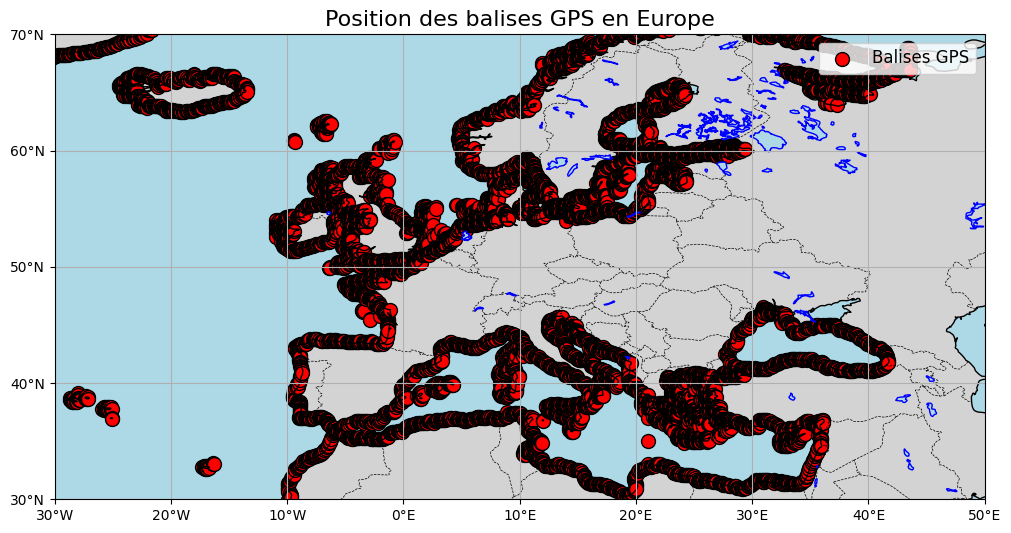

In [72]:
longitude = ds['station_x_coordinate'].values
latitude = ds['station_y_coordinate'].values
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(12, 10))

# Centrer la carte sur l'Europe (limites : longitude et latitude)
ax.set_extent([-30, 50, 30, 70], crs=ccrs.PlateCarree())  # Europe et alentours

ax.add_feature(cfeature.COASTLINE, linewidth=1)  # Lignes de côtes
ax.add_feature(cfeature.BORDERS, linestyle='--', linewidth=0.5)  # Frontières
ax.add_feature(cfeature.LAND, facecolor='lightgray')  # Continents en gris clair
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')  # Océans en bleu clair
ax.add_feature(cfeature.LAKES, edgecolor='blue', facecolor='lightblue')  # Lacs

# Tracer les positions des balises
sc = ax.scatter(longitude, latitude, s=100, color='red', edgecolor='k', transform=ccrs.PlateCarree(), label='Balises GPS')

# Ajouter une légende
ax.legend(fontsize=12, loc='upper right')

# Ajouter une grille de latitude et longitude
ax.grid(True)  # Afficher la grille
ax.set_xticks(range(-30, 51, 10))  # Plages de longitude (modifiables)
ax.set_yticks(range(30, 71, 10))  # Plages de latitude (modifiables)
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x}°E' if x >= 0 else f'{-x}°W'))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y}°N'))

# # Afficher les numéros pour certaines balises seulement
# for i, (lon, lat) in enumerate(zip(longitude, latitude)):
#     # Condition : Afficher les numéros des balises uniquement pour des coordonnées spécifiques
#     if -30 <= lon <= 70 and -10 <= lat <= 70:  # Exemple : afficher les numéros pour ces régions géographiques
#         ax.text(lon, lat, str(i), fontsize=10, ha='right', color='blue', transform=ccrs.PlateCarree())

ax.set_title('Position des balises GPS en Europe', fontsize=16)

plt.show()


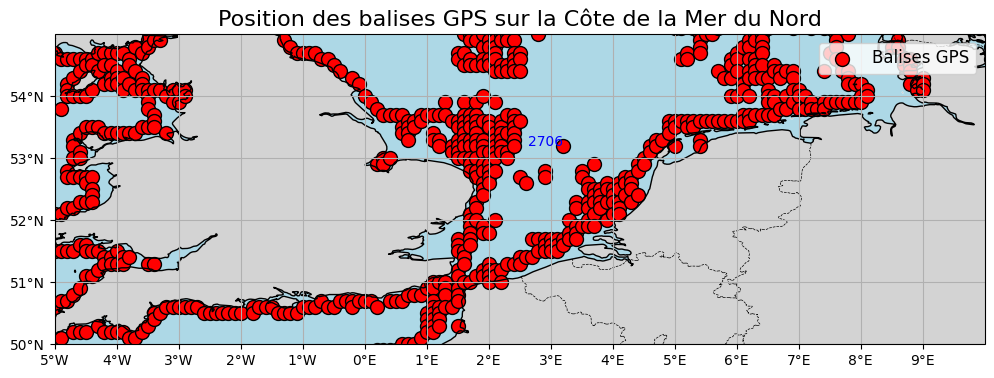

In [31]:
# choix de la balise, arbitraire
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Extraire les coordonnées des stations
longitude = ds['station_x_coordinate'].values
latitude = ds['station_y_coordinate'].values

# Créer une figure avec une projection géographique
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(12, 10))

# Centrer la carte sur la côte de la mer du Nord (limites : longitude et latitude)
ax.set_extent([-5, 10, 50, 55], crs=ccrs.PlateCarree())  # Cote mer du Nord

# Ajouter des fonds de carte
ax.add_feature(cfeature.COASTLINE, linewidth=1)  # Lignes de côtes
ax.add_feature(cfeature.BORDERS, linestyle='--', linewidth=0.5)  # Frontières
ax.add_feature(cfeature.LAND, facecolor='lightgray')  # Continents en gris clair
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')  # Océans en bleu clair

# Tracer les positions des balises
sc = ax.scatter(longitude, latitude, s=100, color='red', edgecolor='k', transform=ccrs.PlateCarree(), label='Balises GPS')
# Ajouter une grille de latitude et longitude
ax.grid(True)  # Afficher la grille
ax.set_xticks(range(-5, 10, 1))  # Plages de longitude (modifiables)
ax.set_yticks(range(50, 55, 1))  # Plages de latitude (modifiables)
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x}°E' if x >= 0 else f'{-x}°W'))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y}°N'))

# Afficher les numéros de chaque balise à côté de sa position
for i, (lon, lat) in enumerate(zip(longitude, latitude)):
    if 3 <= lon <= 4 and 53 <= lat <= 54:  # Afficher uniquement pour la mer du Nord
        ax.text(lon, lat, str(i), fontsize=10, ha='right', color='blue', transform=ccrs.PlateCarree())

# Ajouter une légende
ax.legend(fontsize=12, loc='upper right')

# Ajouter un titre
ax.set_title('Position des balises GPS sur la Côte de la Mer du Nord', fontsize=16)

plt.show()





In [ ]:
# on regarde les séries temporelles sur une balise
temps_moyen_entre_les_vagues_2016_mer_du_nord = xr.open_dataset(netcdf_files[0])['mp1'].isel(locs=2706)
direction_moyene_des_vagues_2016_mer_du_nord = xr.open_dataset(netcdf_files[2])['mwd'].isel(locs=2706)
temps_moyen_entre_les_vagues_energetiques_2016_mer_du_nord = xr.open_dataset(netcdf_files[4])['pp1d'].isel(locs=2706)
hauteur_moyenne_du_tier_des_vagues_les_plus_hautes_2016_mer_du_nord = xr.open_dataset(netcdf_files[6])['swh'].isel(locs=2706)
tables = [
    temps_moyen_entre_les_vagues_2016_mer_du_nord,
    direction_moyene_des_vagues_2016_mer_du_nord,
    temps_moyen_entre_les_vagues_energetiques_2016_mer_du_nord,
    hauteur_moyenne_du_tier_des_vagues_les_plus_hautes_2016_mer_du_nord
]

# Titres correspondants pour chaque variable
titles = [
    "Série temporelle du temps moyen entre les vagues",
    "Série temporelle de la direction moyenne des vagues",
    "Série temporelle de la période des vagues océaniques les plus énergétiques",
    "Série temporelle de la hauteur moyenne (mètre) du tiers le plus élevé des vagues"
]

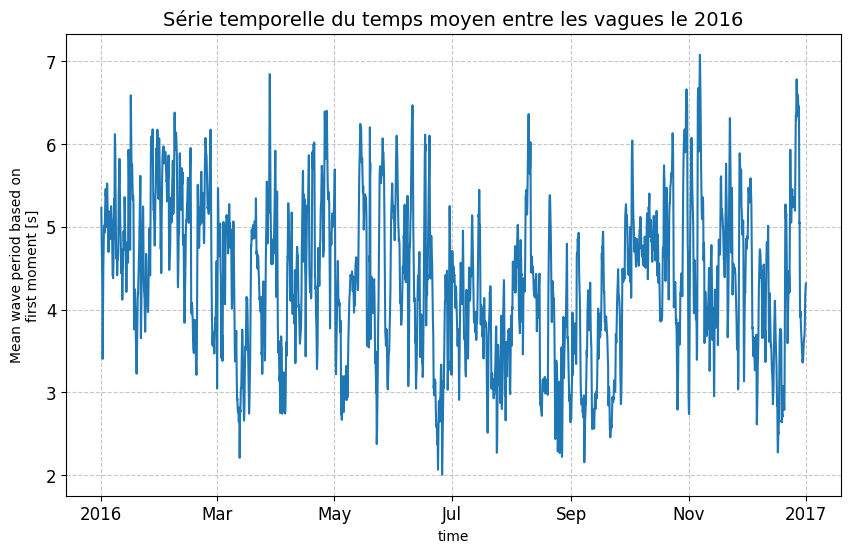

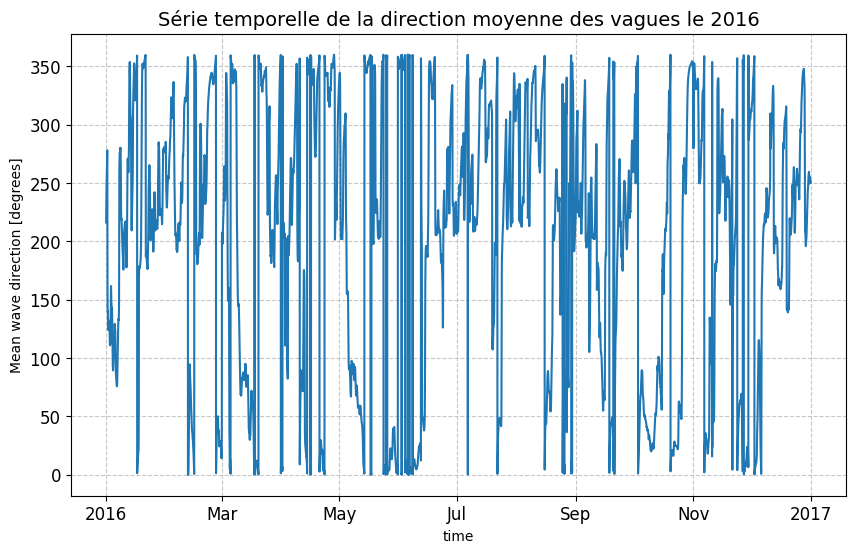

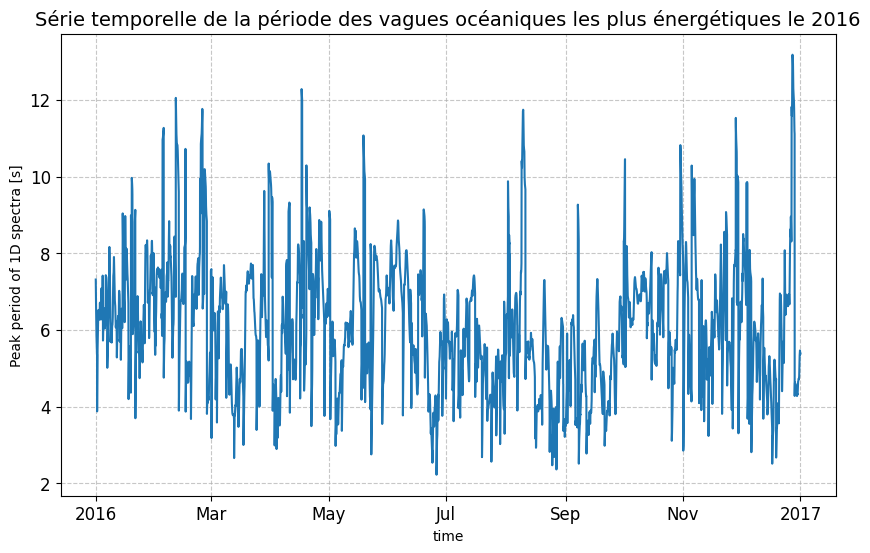

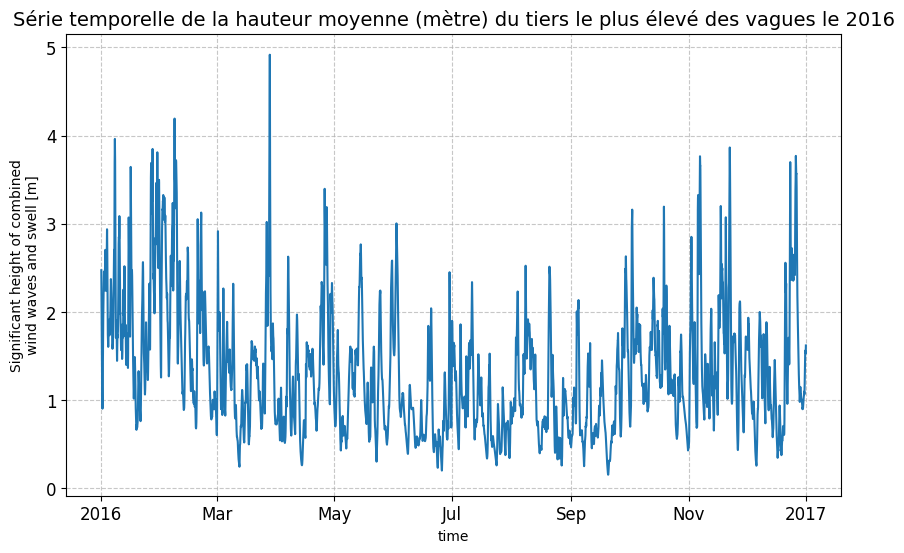

In [71]:
date_filtre = "2016"
for table, title in zip(tables, titles):
    data_filtre = table.sel(time=date_filtre)
    fig, ax = plt.subplots(figsize=(10, 6))
    data_filtre.plot(ax=ax)  # Tracer les données filtrées
    ax.tick_params(axis='both', which='major', labelsize=12)  # Taille des labels des axes
    ax.set_title(f"{title} le {date_filtre}", fontsize=14)  # Ajouter le titre correspondant
    ax.grid(True, linestyle='--', alpha=0.7)
    
    # Afficher le graphique
    plt.show()


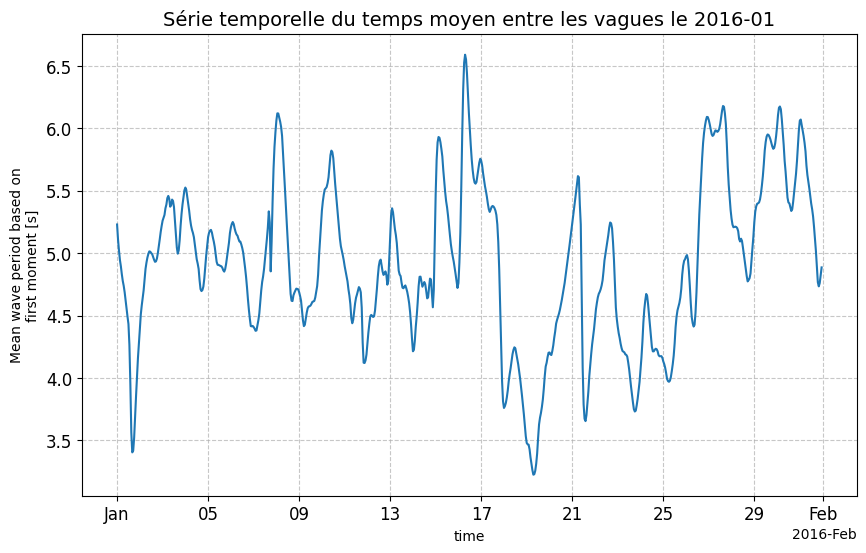

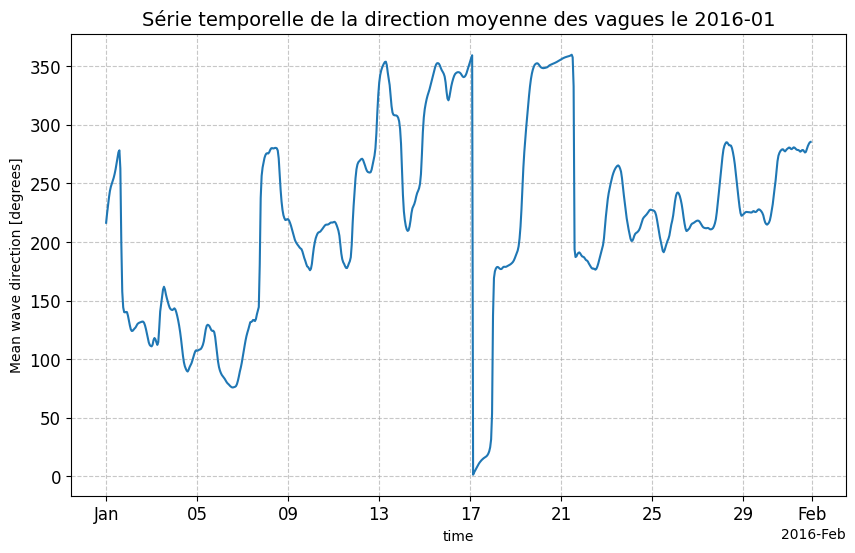

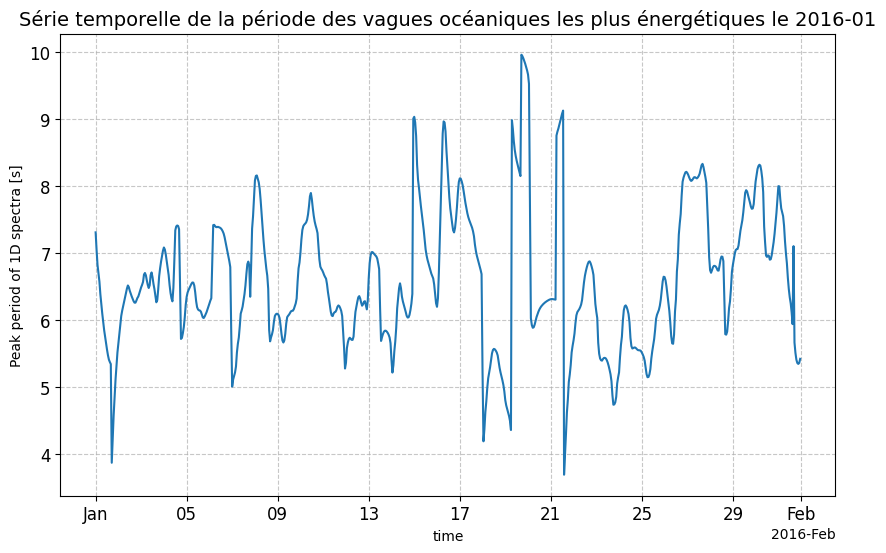

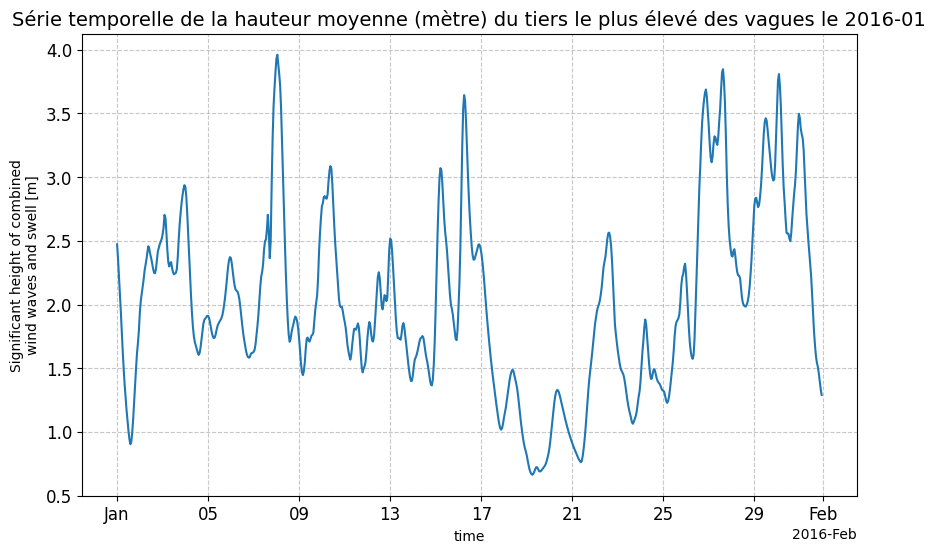

In [70]:
date_filtre = "2016-01"
for table, title in zip(tables, titles):
    data_filtre = table.sel(time=date_filtre)
    fig, ax = plt.subplots(figsize=(10, 6))
    data_filtre.plot(ax=ax)  # Tracer les données filtrées
    ax.tick_params(axis='both', which='major', labelsize=12)  # Taille des labels des axes
    ax.set_title(f"{title} le {date_filtre}", fontsize=14)  # Ajouter le titre correspondant
    ax.grid(True, linestyle='--', alpha=0.7)
    
    # Afficher le graphique
    plt.show()


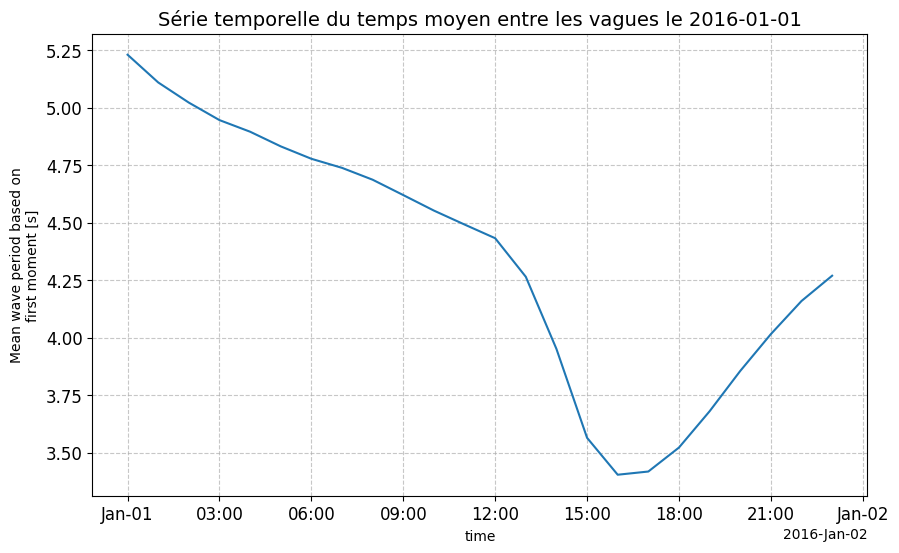

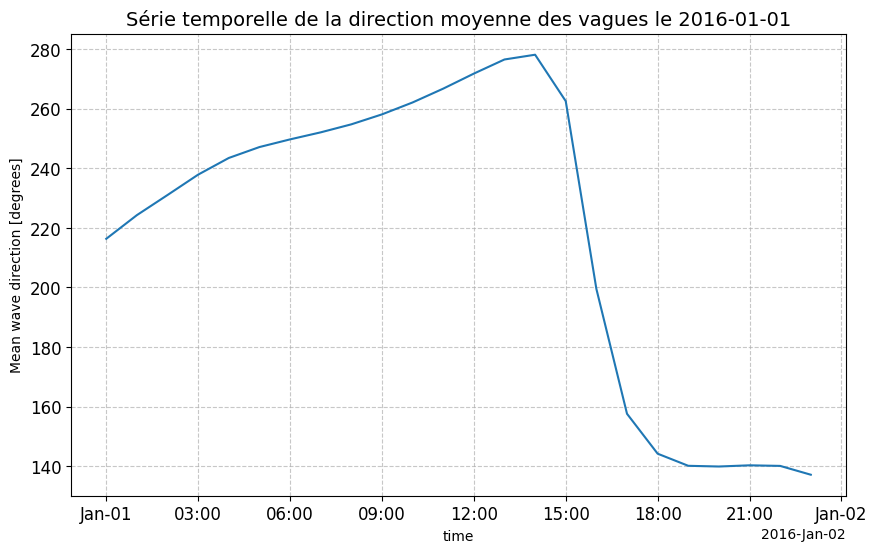

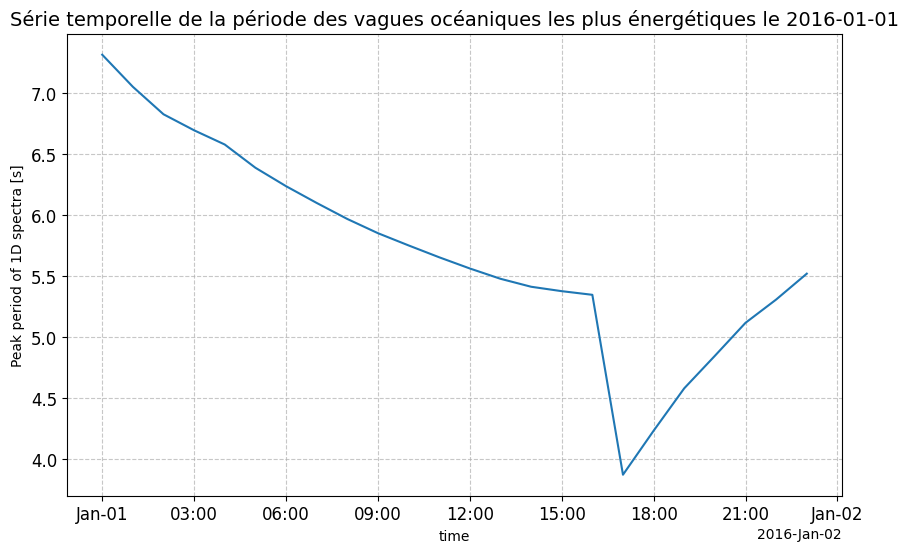

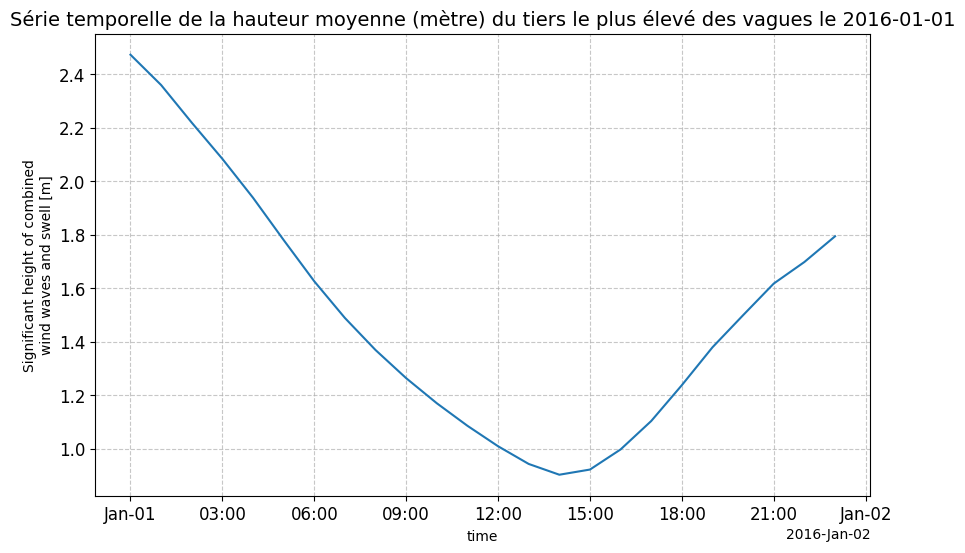

In [69]:
date_filtre = "2016-01-01"
for table, title in zip(tables, titles):
    data_filtre = table.sel(time=date_filtre)
    fig, ax = plt.subplots(figsize=(10, 6))
    data_filtre.plot(ax=ax)  # Tracer les données filtrées
    ax.tick_params(axis='both', which='major', labelsize=12)  # Taille des labels des axes
    ax.set_title(f"{title} le {date_filtre}", fontsize=14)  # Ajouter le titre correspondant
    ax.grid(True, linestyle='--', alpha=0.7)
    
    # Afficher le graphique
    plt.show()


C:\Users\lucas\AppData\Local\Temp\ipykernel_16872\1572480048.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\lucas\AppData\Local\Temp\ipykernel_16872\1572480048.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\lucas\AppData\Local\Temp\ipykernel_16872\1572480048.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\lucas\AppData\Local\Temp\ipykernel_16872\1572480048.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `h

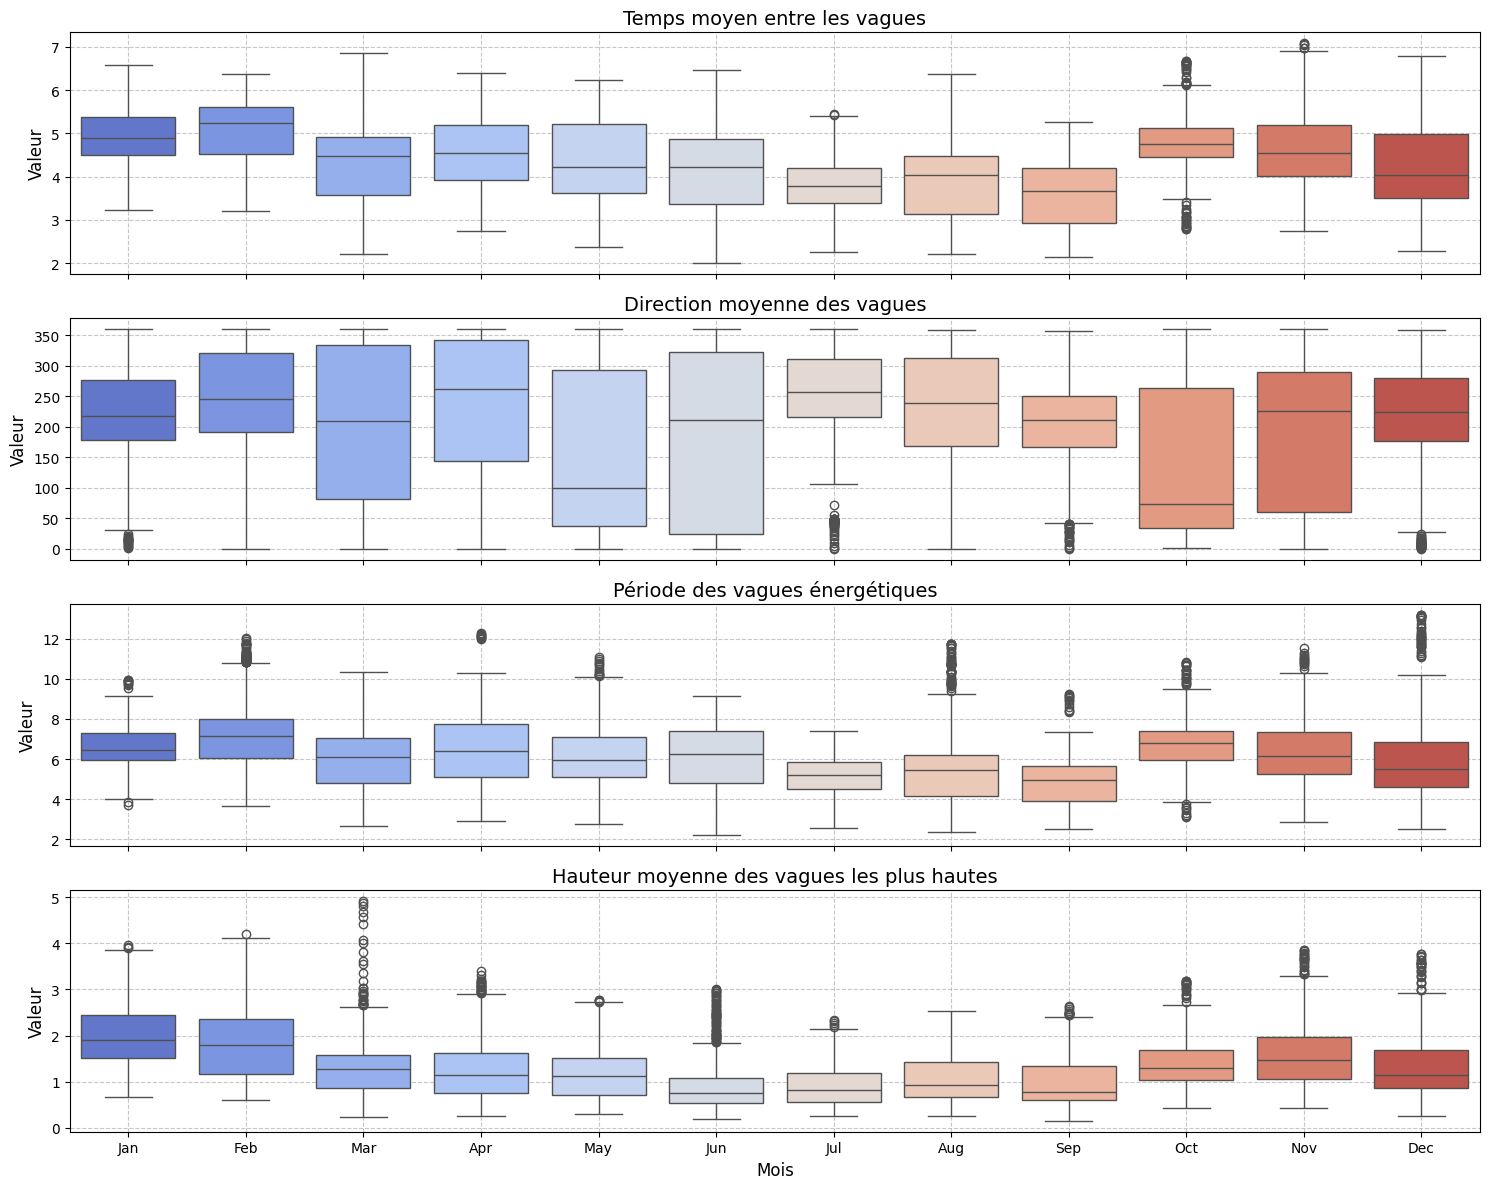

In [74]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

tables = {
    "Temps moyen entre les vagues": temps_moyen_entre_les_vagues_2016_mer_du_nord,
    "Direction moyenne des vagues": direction_moyene_des_vagues_2016_mer_du_nord,
    "Période des vagues énergétiques": temps_moyen_entre_les_vagues_energetiques_2016_mer_du_nord,
    "Hauteur moyenne des vagues les plus hautes": hauteur_moyenne_du_tier_des_vagues_les_plus_hautes_2016_mer_du_nord
}

data_list = []
for name, data in tables.items():
    df = pd.DataFrame({
        "time": data["time"].values,
        "value": data.values,
        "variable": name
    })
    df["Month"] = pd.to_datetime(df["time"]).dt.strftime("%b")  # Extraire le mois
    data_list.append(df)

all_data = pd.concat(data_list, ignore_index=True)

month_order = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

fig, axes = plt.subplots(len(tables), 1, figsize=(15, 12), sharex=True)

for (name, ax) in zip(tables.keys(), axes):
    sns.boxplot(
        data=all_data[all_data["variable"] == name],
        x="Month", y="value",
        ax=ax, order=month_order, palette="coolwarm"
    )
    ax.set_ylabel("Valeur", fontsize=12)
    ax.set_title(name, fontsize=14)
    ax.grid(True, linestyle="--", alpha=0.7)

axes[-1].set_xlabel("Mois", fontsize=12)

plt.tight_layout()

plt.show()


## Analyse de la saisonnalité

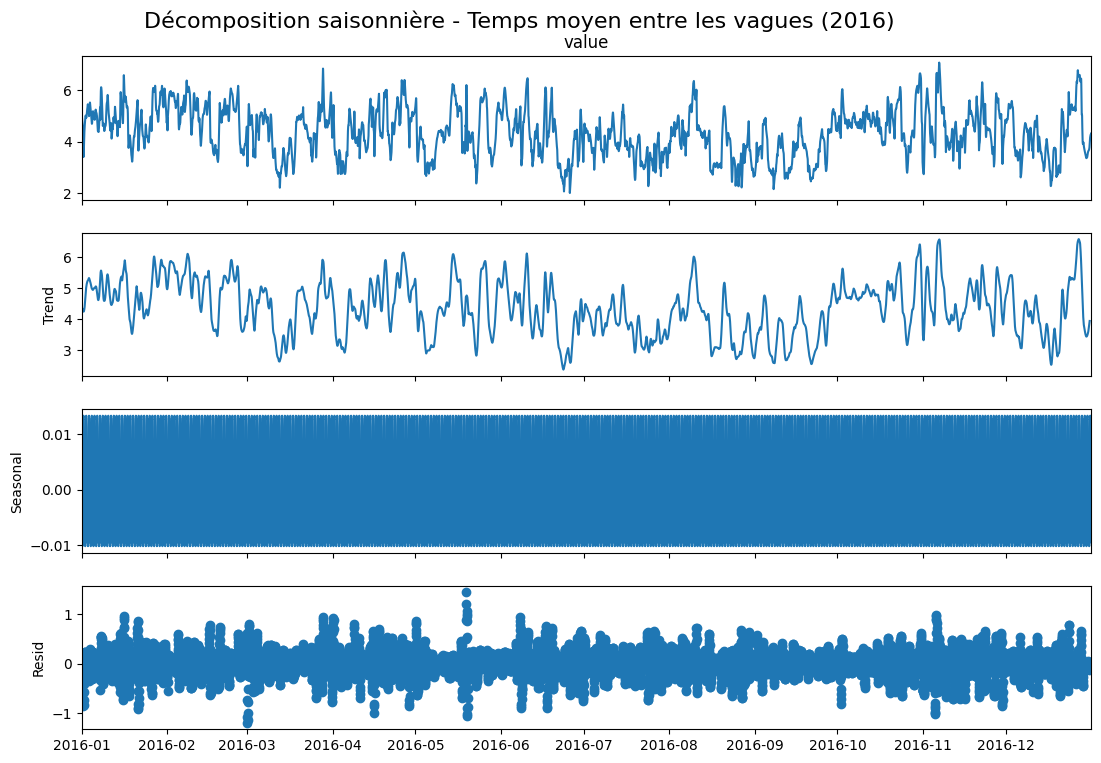

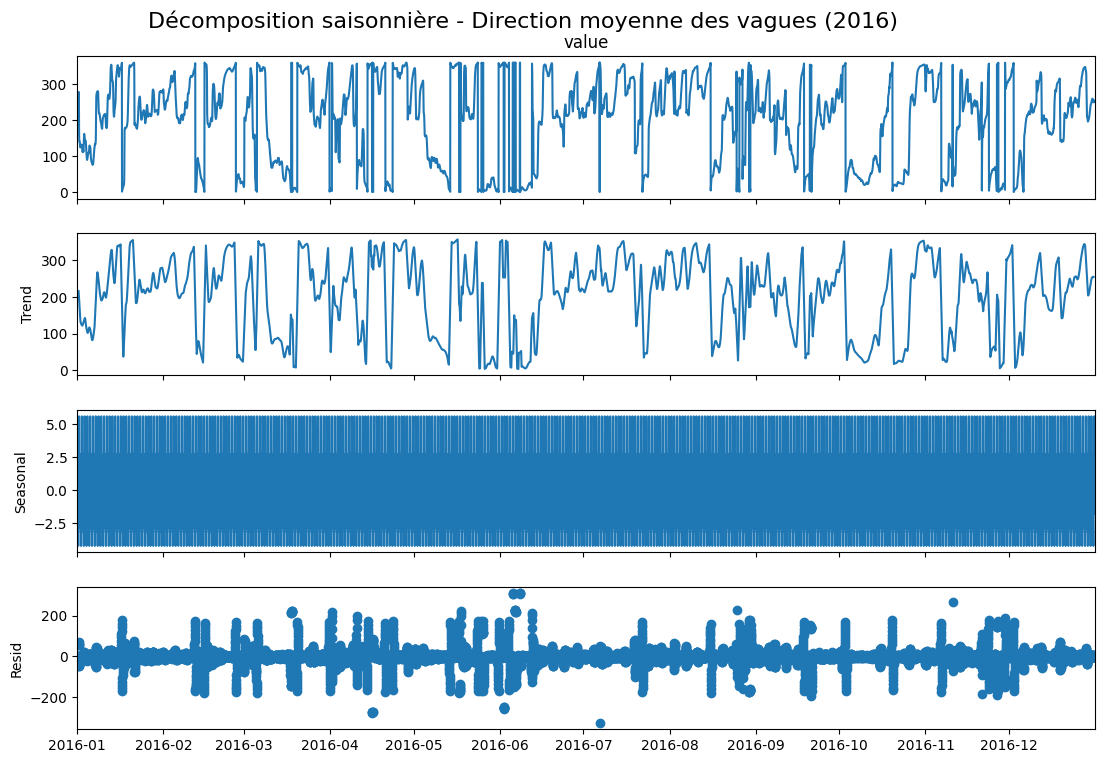

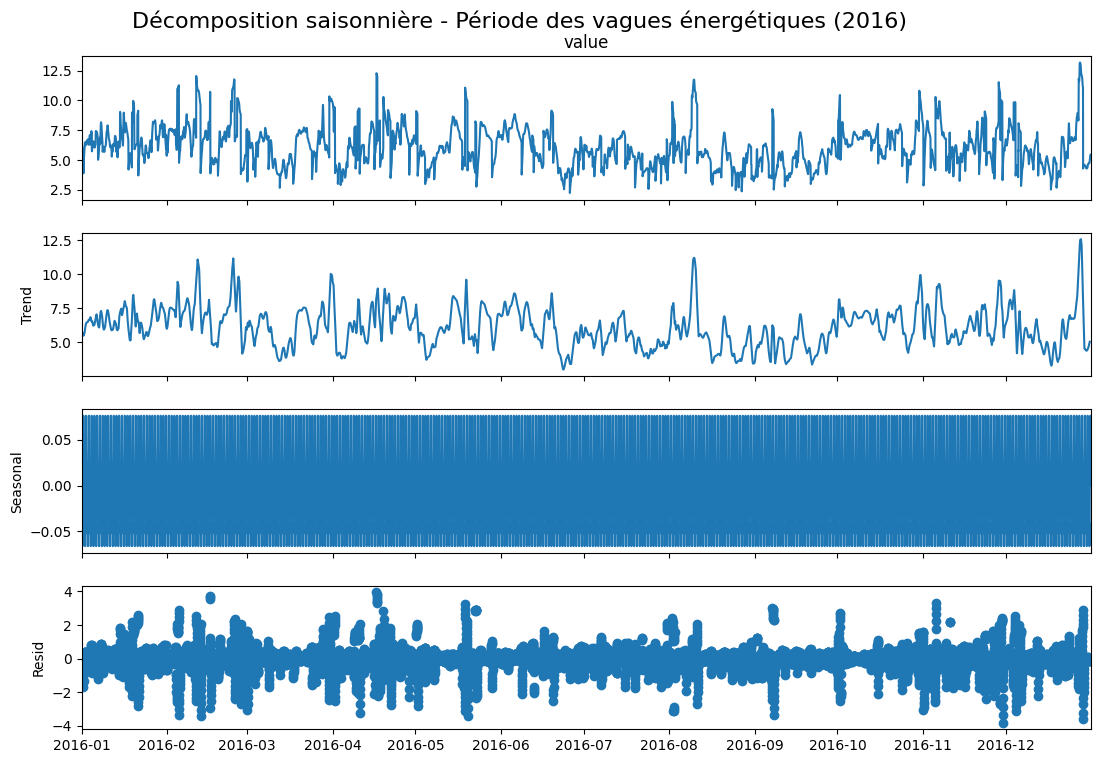

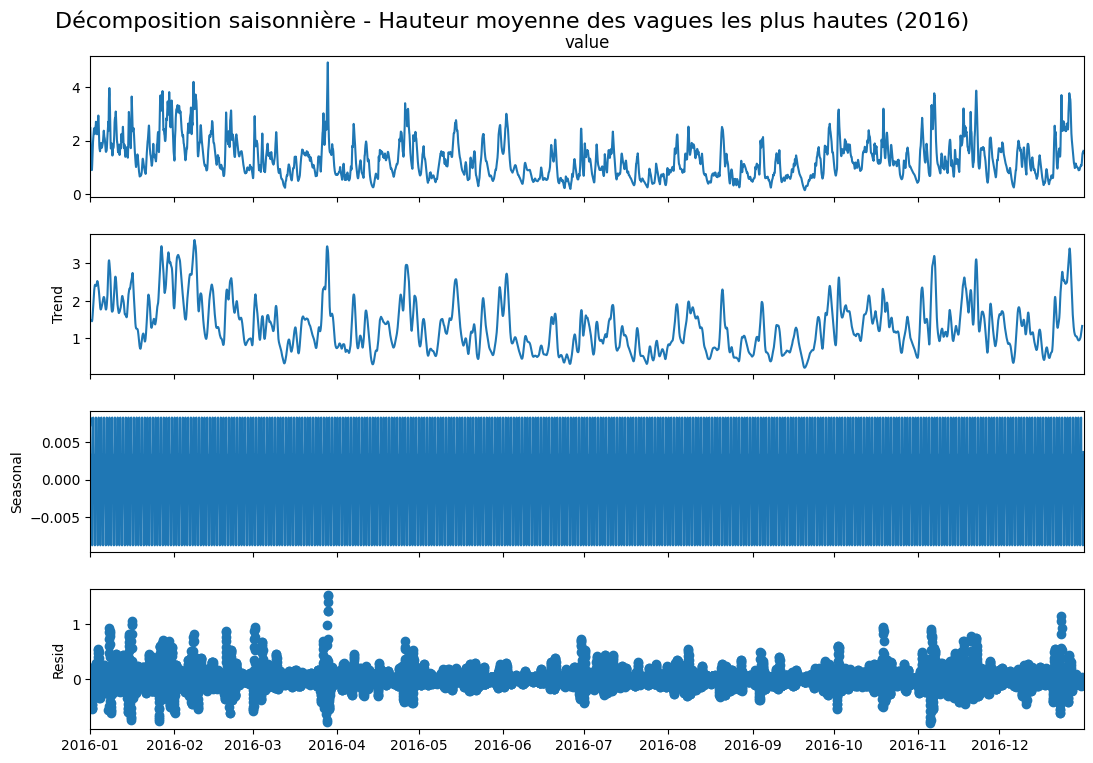

In [ ]:
# Liste des tables NetCDF
tables = {
    "Temps moyen entre les vagues": temps_moyen_entre_les_vagues_2016_mer_du_nord,
    "Direction moyenne des vagues": direction_moyene_des_vagues_2016_mer_du_nord,
    "Période des vagues énergétiques": temps_moyen_entre_les_vagues_energetiques_2016_mer_du_nord,
    "Hauteur moyenne des vagues les plus hautes": hauteur_moyenne_du_tier_des_vagues_les_plus_hautes_2016_mer_du_nord,
}

# Processus automatisé pour chaque table
for name, data in tables.items():
    # Filtrer les données pour le mois spécifié
    # data_filtre = data.sel(time=slice(f"{mois_filtre}-01", f"{mois_filtre}-31"))
    
    # Convertir en DataFrame compatible avec statsmodels
    df = pd.DataFrame({"time": data["time"].values, "value": data.values}).set_index("time")
    
    # Vérifier qu'il y a des données après filtrage
    if len(df) == 0:
        print(f"Pas de données disponibles pour {name} en {mois_filtre}.")
        continue
    
    # Effectuer la décomposition saisonnière
    decomposition = seasonal_decompose(df["value"], model="additive", period=24)  # Période = 24 heures (ajustable)
    
    # Tracer le résultat
    fig = decomposition.plot()
    fig.suptitle(f"Décomposition saisonnière - {name} ({mois_filtre})", fontsize=16)  # Ajouter un titre
    fig.set_size_inches(12, 8)  # Ajuster la taille du graphique
    plt.show()


In [ ]:
# # Dunkerke
# lat_target = 56
# lon_target = 4

# filtered_datasets = []
# for file in netcdf_files:
#     # Charger le fichier NetCDF avec xarray
#     ds = xr.open_dataset(file)
    
#     # Utiliser "locs" pour sélectionner les indices de stations les plus proches
#     filtered_data = ds.sel(locs=1000)
#     df = filtered_data.to_dataframe().reset_index()

#     # Ajouter le dataset filtré à la liste
#     filtered_datasets.append(df)



## Anlayse de la stationnarité faible



Par ex : Relation linéaire entre période 3 et 5 ?
Faible stationnarité sur moment 2 implique que l’autovariance dépend que de t-s mais pas de t ni de s. Donc même effet entre 3 et 5 et 4 et 6. Le poids du passé reste égal dans le temps = stationnaire. 

Si le processus admet une espérance constante, une variance et une covariance qui d"pendent du temps. Le processus, n'est pas stationnaire 

DF augmenté : si résidus ne sont pas blanc, DF est faux. 

Test de stationnarité (ADF) :

Nous appliquons le test ADF sur les séries d'origine pour déterminer si elles sont stationnaires (I(0)).
Si la p-valeur du test est inférieure à 0.05, cela signifie que la série est stationnaire (I(0)).
Sinon, nous poursuivons la différenciation.
Différenciation (I(1) et I(2)) :
Si la série n'est pas stationnaire après le test ADF, nous procédons à une différenciation d'ordre 1 (I(1)) et testons à nouveau la stationnarité avec ADF.
Si la série est toujours non stationnaire après I(1), nous effectuons une différenciation d'ordre 2 (I(2)) et refaisons le test.

In [ ]:
tables = {
    "Temps moyen entre les vagues": temps_moyen_entre_les_vagues_2016_mer_du_nord,
    "Direction moyenne des vagues": direction_moyene_des_vagues_2016_mer_du_nord,
    "Période des vagues énergétiques": temps_moyen_entre_les_vagues_energetiques_2016_mer_du_nord,
    "Hauteur moyenne des vagues les plus hautes": hauteur_moyenne_du_tier_des_vagues_les_plus_hautes_2016_mer_du_nord,
}
# Fonction pour tester la stationnarité avec ADF
def test_stationarity(series, name="Série"):
    """
    Test de stationnarité sur une série temporelle avec le test ADF.
    """
    print(f"\nTest de stationnarité pour : {name}")
    
    # Suppression des valeurs manquantes en fonction de la dimension 'time'
    series_clean = series.dropna(dim='time')
    
    adf_test = adfuller(series_clean)  # ADF sur les données sans valeurs manquantes
    adf_stat, p_value, lags, obs, crit_values, icbest = adf_test

    print(f"Statistique ADF : {adf_stat:.3f}")
    print(f"P-valeur : {p_value:.3g}")
    print(f"Lags utilisés : {lags}")
    print(f"Valeurs critiques : {crit_values}")

    if p_value < 0.05:
        print(f"La série '{name}' est stationnaire (H0 rejetée).")
        return "I(0)"  # Stationnaire
    else:
        print(f"La série '{name}' n'est PAS stationnaire (H0 non rejetée).")
        return "Non stationnaire"

# Fonction pour effectuer une différenciation (ordre 1 ou 2)
def differentiate(series, order=1):
    """
    Effectuer une différenciation d'ordre spécifié sur une série temporelle.
    """
    return series.diff(dim='time', periods=order).dropna(dim='time')  # Différenciation et suppression des NaN

# Analyser les séries et tester la stationnarité
for name, data in tables.items():
    print(f"\n=== Analyse de stationnarité pour : {name} ===")
    
    # Test de stationnarité pour la série d'origine (I(0))
    result = test_stationarity(data, name=name)
    
    if result == "Non stationnaire":
        # Différencier d'ordre 1 (I(1)) et tester à nouveau
        data_diff_1 = differentiate(data, order=1)
        print(f"\nSérie différenciée d'ordre 1 pour {name}:")
        test_stationarity(data_diff_1, name=f"{name} - Différenciée d'ordre 1")
        
        # Si la série n'est pas stationnaire après différenciation d'ordre 1, différencier d'ordre 2 (I(2))
        data_diff_2 = differentiate(data_diff_1, order=1)
        print(f"\nSérie différenciée d'ordre 2 pour {name}:")
        test_stationarity(data_diff_2, name=f"{name} - Différenciée d'ordre 2")



=== Analyse de stationnarité pour : Temps moyen entre les vagues ===

Test de stationnarité pour : Temps moyen entre les vagues
Statistique ADF : -8.525
P-valeur : 1.08e-13
Lags utilisés : 27
Valeurs critiques : {'1%': np.float64(-3.4310970555186726), '5%': np.float64(-2.861870148935175), '10%': np.float64(-2.566945733303859)}
La série 'Temps moyen entre les vagues' est stationnaire (H0 rejetée).

=== Analyse de stationnarité pour : Direction moyenne des vagues ===

Test de stationnarité pour : Direction moyenne des vagues
Statistique ADF : -10.359
P-valeur : 2.43e-18
Lags utilisés : 13
Valeurs critiques : {'1%': np.float64(-3.431095862606368), '5%': np.float64(-2.8618696218133186), '10%': np.float64(-2.566945452713394)}
La série 'Direction moyenne des vagues' est stationnaire (H0 rejetée).

=== Analyse de stationnarité pour : Période des vagues énergétiques ===

Test de stationnarité pour : Période des vagues énergétiques
Statistique ADF : -9.903
P-valeur : 3.31e-17
Lags utilisés : 2

## autocorrélation et autocorrélation partielle

Analyse de la série : Temps moyen entre les vagues


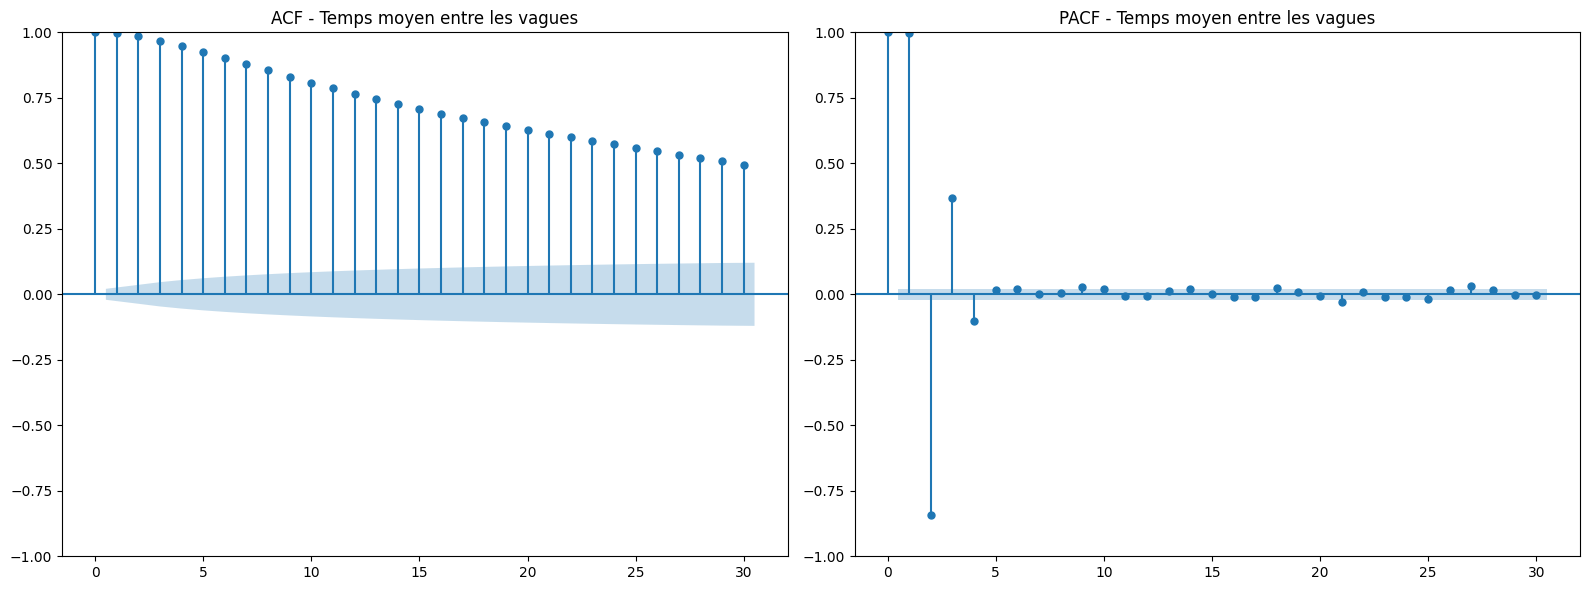

Analyse de la série : Direction moyenne des vagues


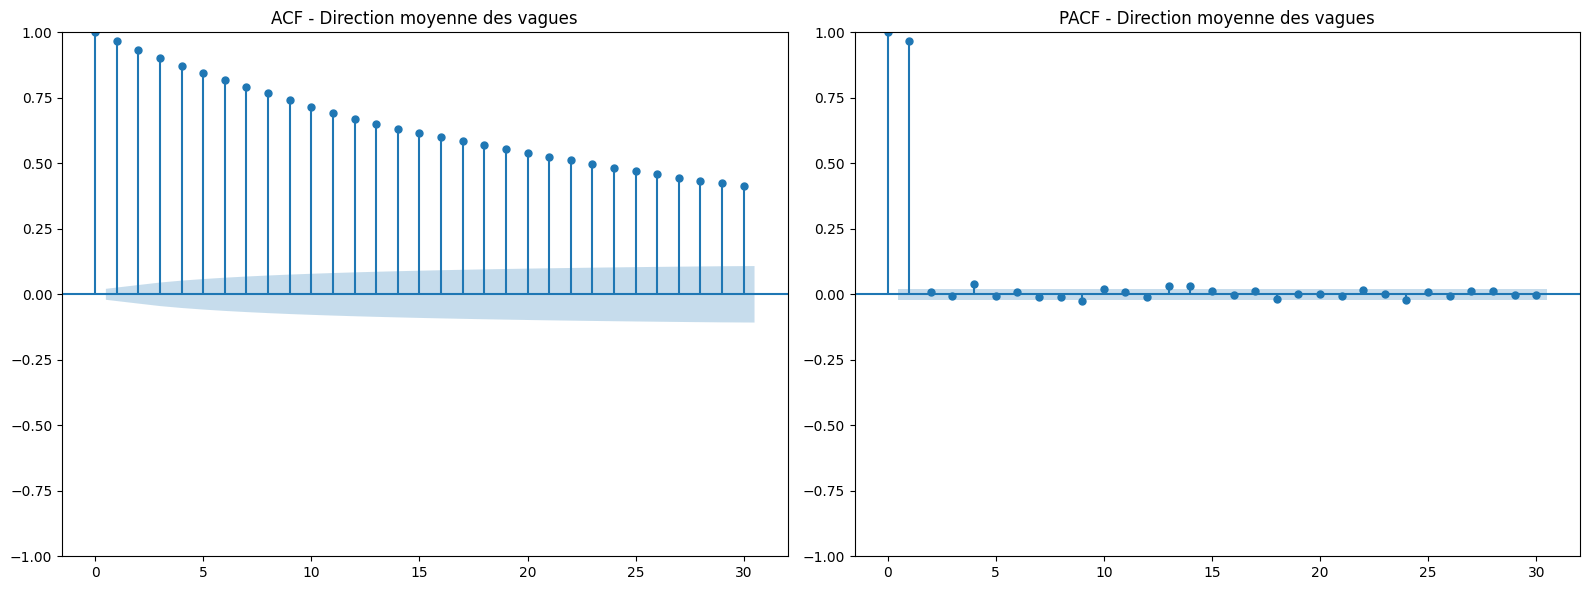

Analyse de la série : Période des vagues énergétiques


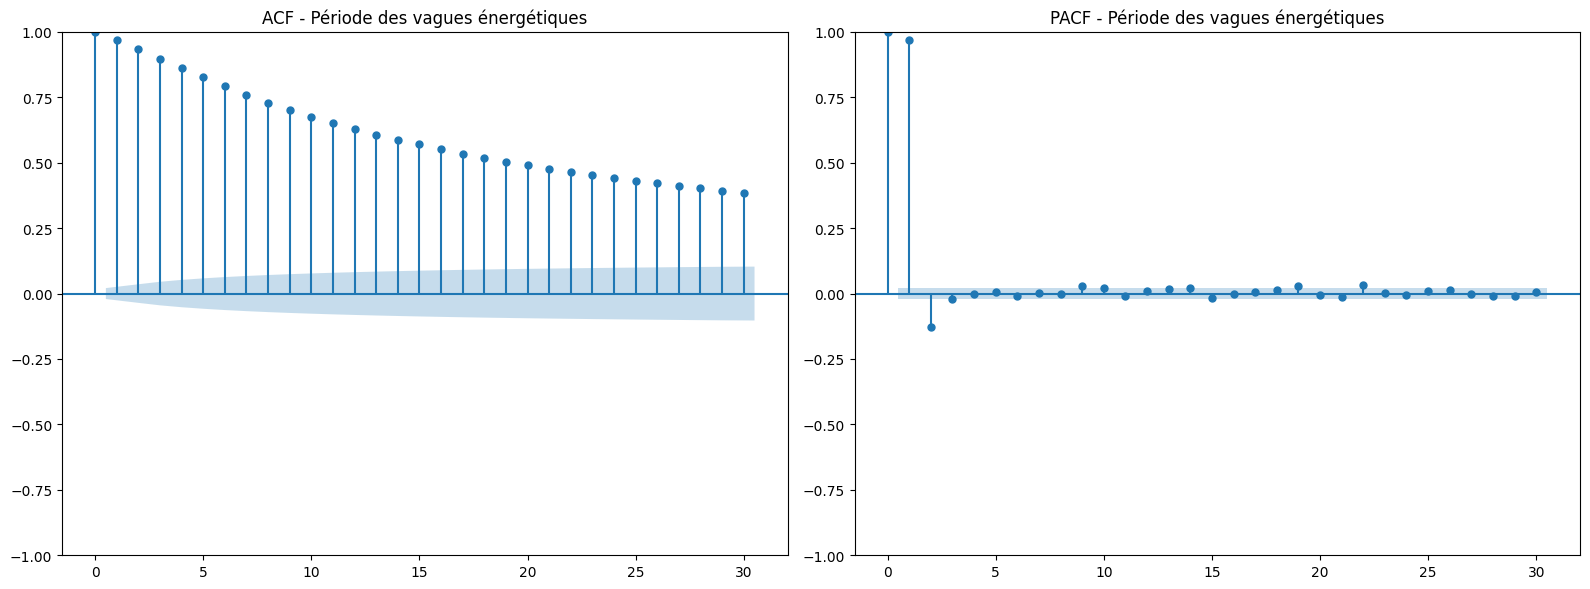

Analyse de la série : Hauteur moyenne des vagues les plus hautes


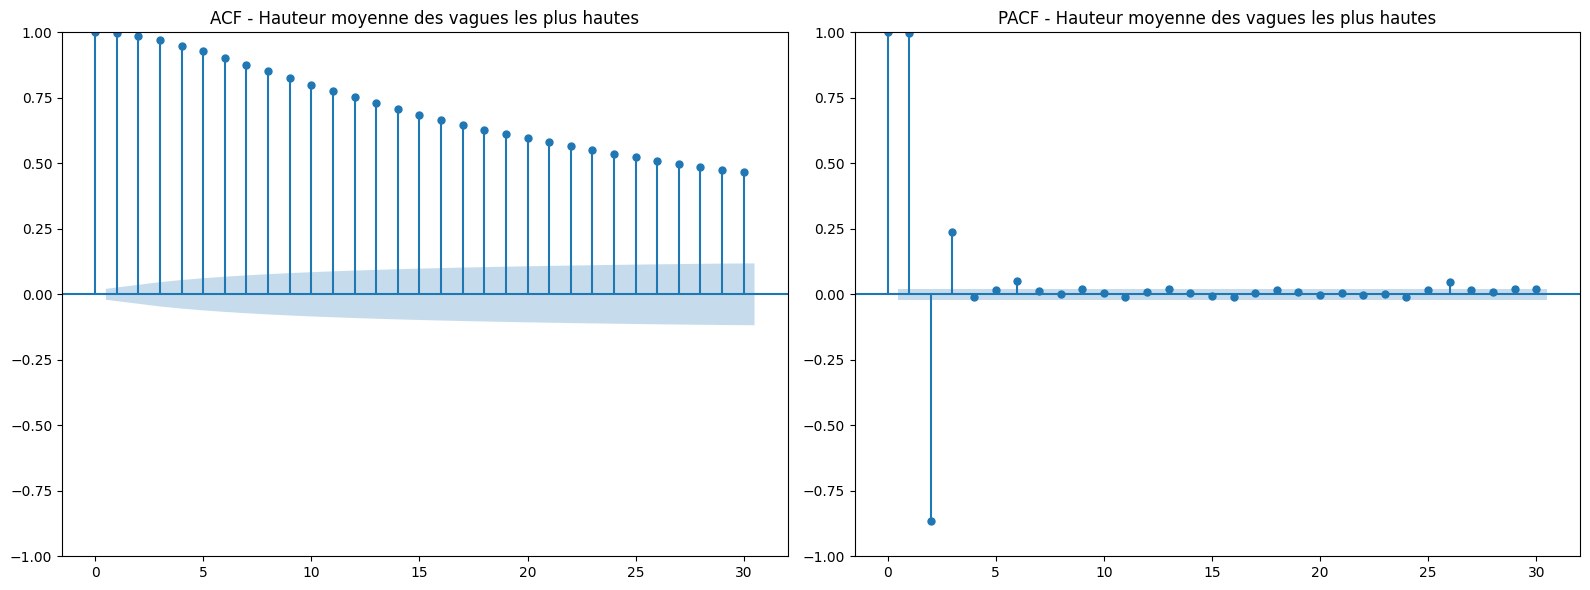

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

tables = {
    "Temps moyen entre les vagues": temps_moyen_entre_les_vagues_2016_mer_du_nord,
    "Direction moyenne des vagues": direction_moyene_des_vagues_2016_mer_du_nord,
    "Période des vagues énergétiques": temps_moyen_entre_les_vagues_energetiques_2016_mer_du_nord,
    "Hauteur moyenne des vagues les plus hautes": hauteur_moyenne_du_tier_des_vagues_les_plus_hautes_2016_mer_du_nord,
}

for name, data in tables.items():
    print(f"Analyse de la série : {name}")
    series = data.values
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    plot_acf(series, lags=30, ax=axes[0])
    axes[0].set_title(f'ACF - {name}')
    plot_pacf(series, lags=30, ax=axes[1])
    axes[1].set_title(f'PACF - {name}')
    plt.tight_layout()
    plt.show()


L'ACF montre une décroissance progressive des corrélations avec l'augmentation du lag.
La PACF montrera une coupure nette après le deux, troisième ou cinquième lag selon la série, indiquant que seul ces premiers décalages ont ne corrélation significative une fois les autres lags pris en compte.
En résumé les séries sont très périodiques

# Préprocessing

à faire : 
 
 Preprocessing 
- filtre par ondelette Wavelet denoising (décomposition de fourrier)
- transformation variable dégré en degré par du cos ou sin (passage donnée polaire en donnée cartésienne).direction de 1° est très proche sur une cercle de la direction 359°.

Les méthod
- stationnarité, co intégration avec les autres variables ?
- mice pour NA
- ts fresh pour créer variable
- créer des variables à partir du temps
- choisir métrique
- bien decouper entrainement et test 


## passage données polaire en données cartésienne pour les variables de direction
cos(radians)


In [90]:

direction_radians = np.deg2rad(direction_moyene_des_vagues_2016_mer_du_nord)  # Convertir les degrés en radians
direction_moyene_des_vagues_2016_mer_du_nord_en_cos = np.cos(direction_radians)  # Calculer le cosinus

# Stocker le résultat dans une nouvelle variable
direction_moyene_des_vagues_2016_mer_du_nord_en_cos.attrs = direction_moyene_des_vagues_2016_mer_du_nord.attrs  # Conserver les métadonnées
direction_moyene_des_vagues_2016_mer_du_nord_en_cos.name = "Cosinus de la direction moyenne des vagues"

# Afficher un aperçu des données
print(direction_moyene_des_vagues_2016_mer_du_nord_en_cos)


<xarray.DataArray 'Cosinus de la direction moyenne des vagues' (time: 8784)> Size: 70kB
array([-0.80536101, -0.71571194, -0.62856875, ..., -0.30286986,
       -0.31781744, -0.33557824])
Coordinates:
  * time                  (time) datetime64[ns] 70kB 2016-01-01 ... 2016-12-3...
    station_x_coordinate  float64 8B ...
    station_y_coordinate  float64 8B ...
Attributes:
    units:       degrees
    long_name:   Mean wave direction
    short_name:  Mean wave direction


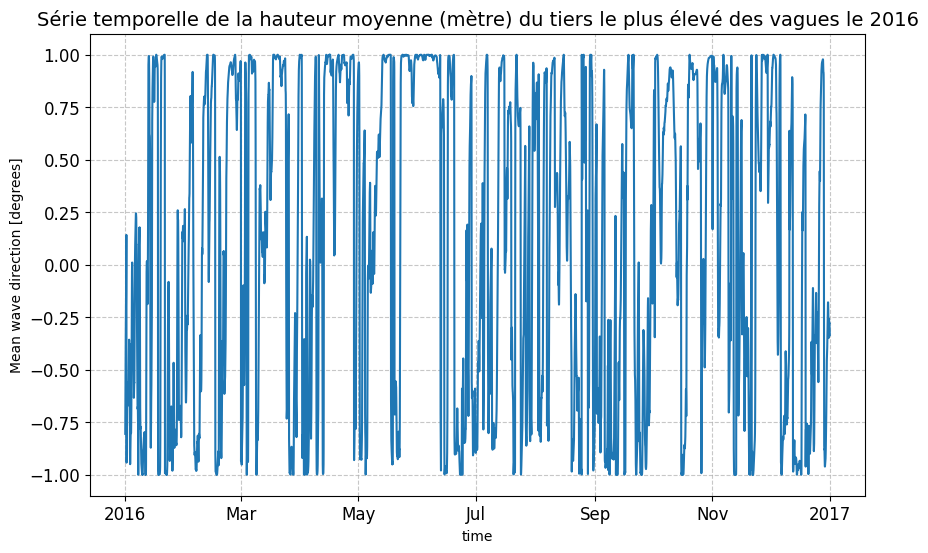

In [93]:
date_filtre = "2016"
table = direction_moyene_des_vagues_2016_mer_du_nord_en_cos
data_filtre = table.sel(time=date_filtre)
fig, ax = plt.subplots(figsize=(10, 6))
data_filtre.plot(ax=ax)  # Tracer les données filtrées
ax.tick_params(axis='both', which='major', labelsize=12)  # Taille des labels des axes
ax.set_title(f"{title} le {date_filtre}", fontsize=14)  # Ajouter le titre correspondant
ax.grid(True, linestyle='--', alpha=0.7)
    
    # Afficher le graphique
plt.show()


## filtre par ondelette


sym5 (Symlets) : Bonne approximation des signaux lisses, adaptée aux phénomènes naturels.
coif1 (Coiflets) : Plus adaptée pour les signaux contenant des variations subtiles, souvent utilisée pour les données environnementales.
Pour des séries longues (1 an avec des pas horaires, soit ~8760 points), un niveau de 4 à 6 est souvent idéal
Pour une sous-série (par exemple, un mois, 720 points), utilisez un niveau de 3
Une année à raison de 8 points par jour (24 heures / 3 heures) correspond à environ 2920 observations.


Traitement de la table : Temps moyen entre les vagues


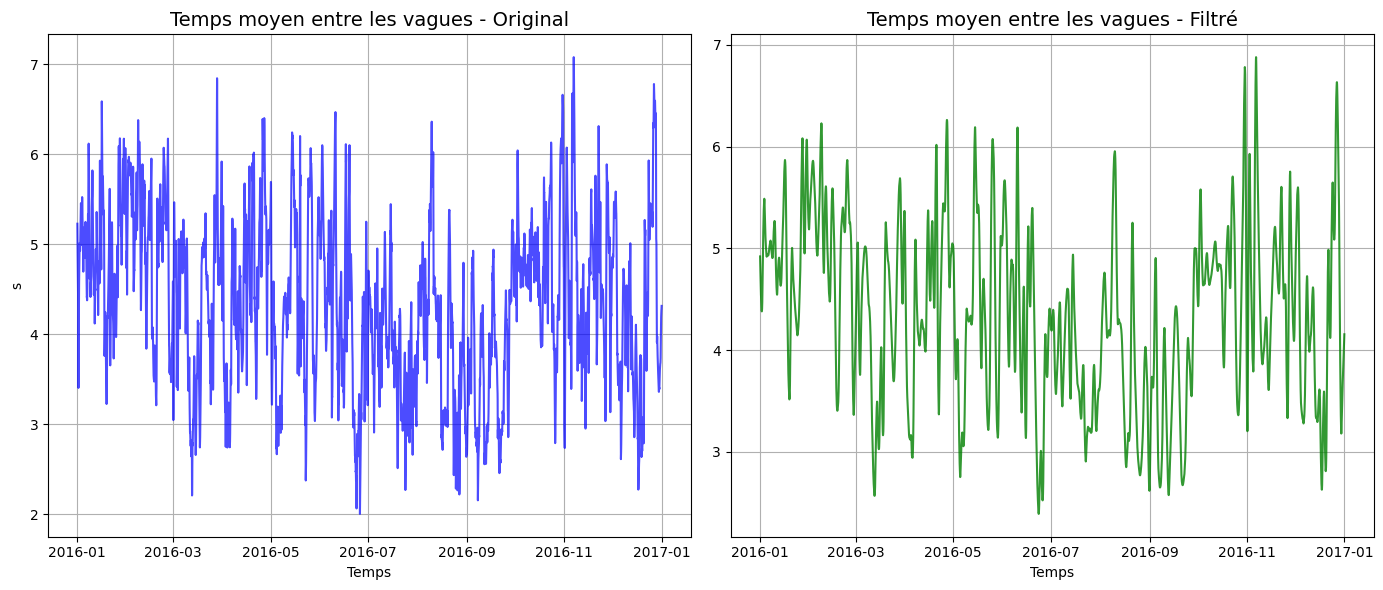

Traitement de la table : Direction moyenne des vagues


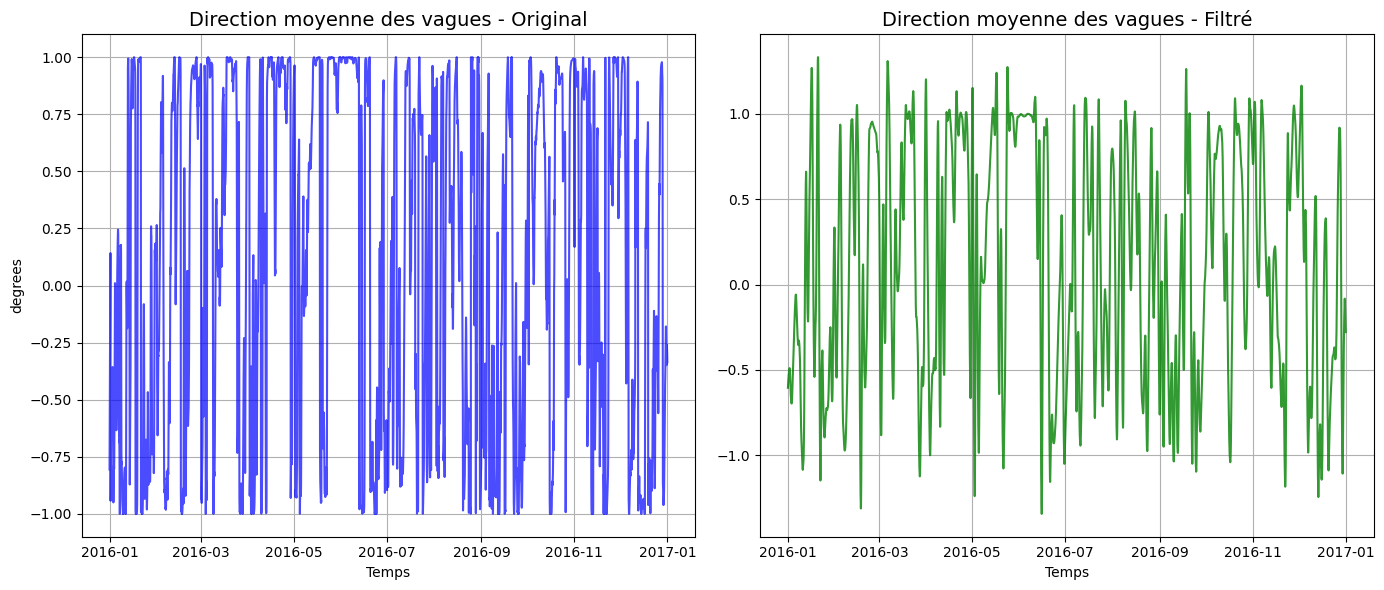

Traitement de la table : Période des vagues énergétiques


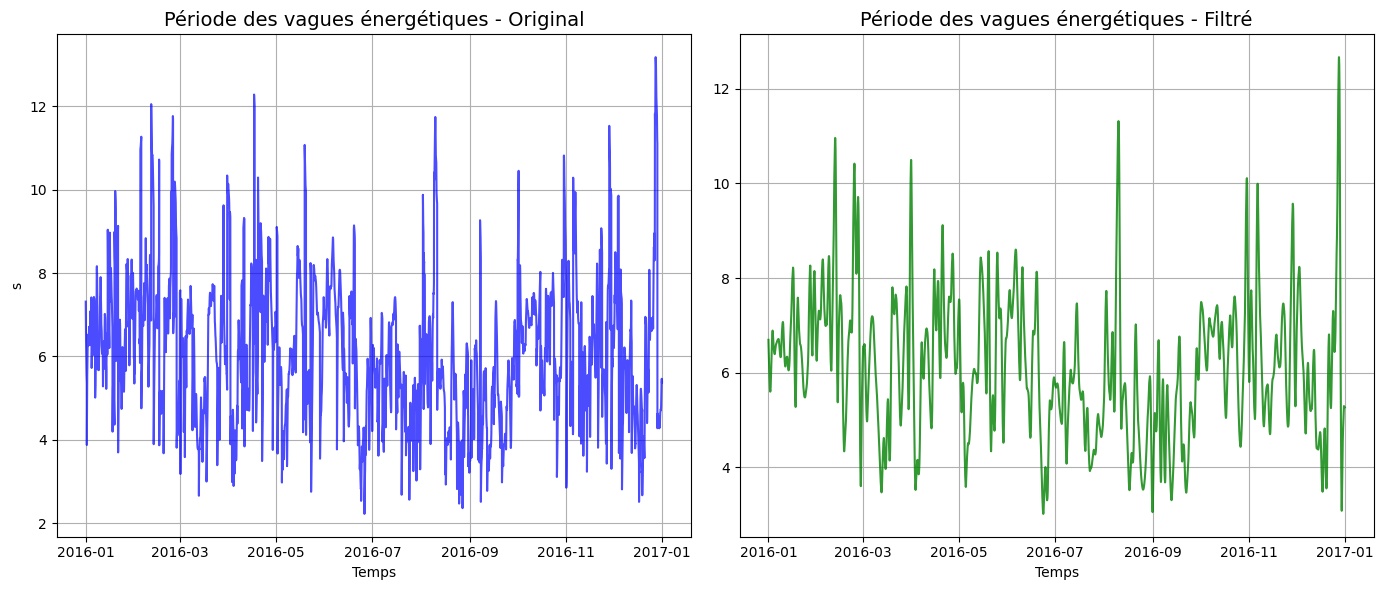

Traitement de la table : Hauteur moyenne des vagues les plus hautes


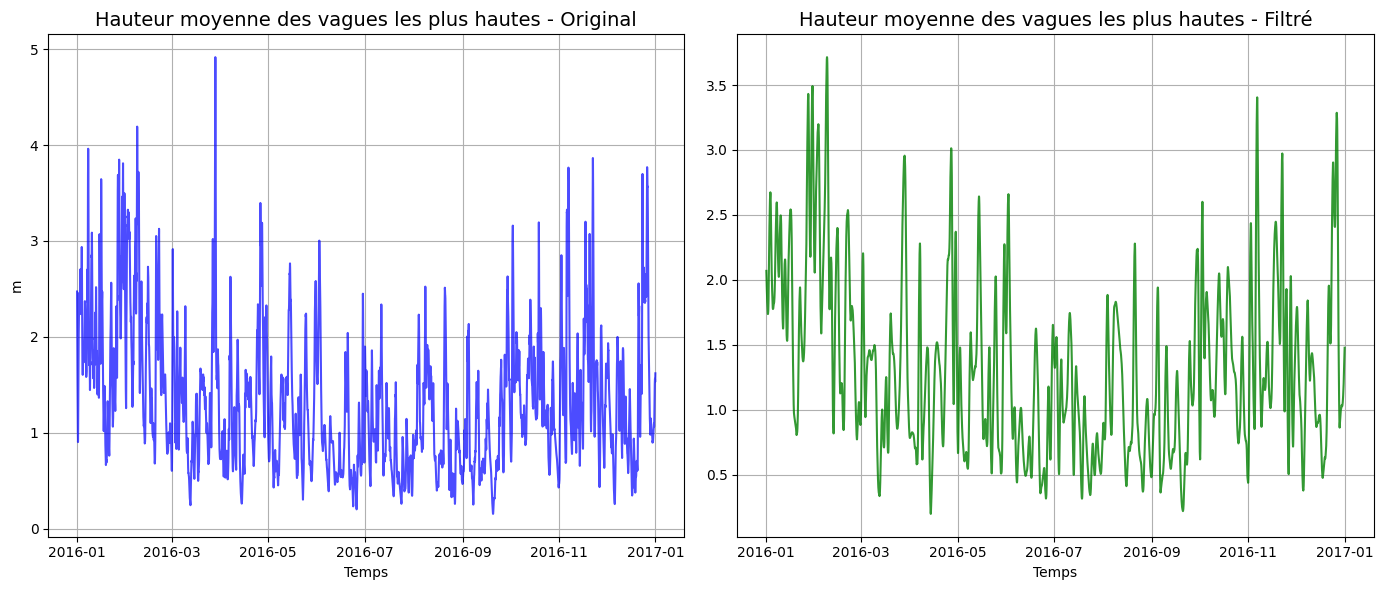

In [146]:
# Paramètres adaptés aux données climatiques
wavelet = 'sym5'  # Ondelette Symlets 5
level = 5  # Niveau de décomposition pour des séries climatiques (ajusté à la longueur des données)

tables = {
    "Temps moyen entre les vagues": temps_moyen_entre_les_vagues_2016_mer_du_nord,
    "Direction moyenne des vagues": direction_moyene_des_vagues_2016_mer_du_nord_en_cos,
    "Période des vagues énergétiques": temps_moyen_entre_les_vagues_energetiques_2016_mer_du_nord,
    "Hauteur moyenne des vagues les plus hautes": hauteur_moyenne_du_tier_des_vagues_les_plus_hautes_2016_mer_du_nord,

}
for name, data in tables.items():
    print(f"Traitement de la table : {name}")
    
    signal = data.values
    
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    
    coeffs_filtered = coeffs[:]
    for i in range(1, len(coeffs_filtered)):  # Supprimer les détails (high-pass)
        coeffs_filtered[i] = np.zeros_like(coeffs_filtered[i])
    
    signal_filtered = pywt.waverec(coeffs_filtered, wavelet)
    
    filtered_data = xr.DataArray(
        signal_filtered[:len(signal)],  # Ajuster la longueur au cas où
        dims=data.dims,
        coords=data.coords,
        attrs=data.attrs
    )
    filtered_data.name = f"{name} (Filtré)"
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    axes[0].plot(data["time"], signal, color="blue", alpha=0.7)
    axes[0].set_title(f"{name} - Original", fontsize=14)
    axes[0].set_xlabel("Temps")
    axes[0].set_ylabel(data.attrs.get('units', 'Valeurs'))
    axes[0].grid(True)
    axes[1].plot(data["time"], signal_filtered[:len(signal)], color="green", alpha=0.8)
    axes[1].set_title(f"{name} - Filtré", fontsize=14)
    axes[1].set_xlabel("Temps")
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.show()


In [147]:
temps_moyen_entre_les_vagues_2016_mer_du_nord_filtre = temps_moyen_entre_les_vagues_2016_mer_du_nord.copy()
direction_moyene_des_vagues_2016_mer_du_nord_en_cos_filtre = direction_moyene_des_vagues_2016_mer_du_nord_en_cos.copy()
temps_moyen_entre_les_vagues_energetiques_2016_mer_du_nord_filtre = temps_moyen_entre_les_vagues_energetiques_2016_mer_du_nord.copy()
hauteur_moyenne_du_tier_des_vagues_les_plus_hautes_2016_mer_du_nord_filtre = hauteur_moyenne_du_tier_des_vagues_les_plus_hautes_2016_mer_du_nord.copy()


def filtrage_par_ondelette(data, wavelet, level):
    # Extraction du signal brut
    signal = data.values

    # Décomposition en ondelettes
    coeffs = pywt.wavedec(signal, wavelet, level=level)

    for i in range(1, len(coeffs)):
        coeffs[i] = np.zeros_like(coeffs[i])

    signal_filtered = pywt.waverec(coeffs, wavelet)

    signal_filtered = signal_filtered[:len(signal)]

    return xr.DataArray(
        signal_filtered,
        dims=data.dims,
        coords=data.coords,
        attrs=data.attrs,
    )

# Application du filtrage à chaque table
temps_moyen_entre_les_vagues_2016_mer_du_nord_filtre = filtrage_par_ondelette(
    temps_moyen_entre_les_vagues_2016_mer_du_nord_filtre, wavelet, level
)

direction_moyene_des_vagues_2016_mer_du_nord_en_cos_filtre = filtrage_par_ondelette(
    direction_moyene_des_vagues_2016_mer_du_nord_en_cos_filtre, wavelet, level
)

temps_moyen_entre_les_vagues_energetiques_2016_mer_du_nord_filtre = filtrage_par_ondelette(
    temps_moyen_entre_les_vagues_energetiques_2016_mer_du_nord_filtre, wavelet, level
)

hauteur_moyenne_du_tier_des_vagues_les_plus_hautes_2016_mer_du_nord_filtre = filtrage_par_ondelette(
    hauteur_moyenne_du_tier_des_vagues_les_plus_hautes_2016_mer_du_nord_filtre, wavelet, level
)


## NA

In [148]:
tables = {
    "Temps moyen entre les vagues": temps_moyen_entre_les_vagues_2016_mer_du_nord,
    "Direction moyenne des vagues": direction_moyene_des_vagues_2016_mer_du_nord,
    "Période des vagues énergétiques": temps_moyen_entre_les_vagues_energetiques_2016_mer_du_nord,
    "Hauteur moyenne des vagues les plus hautes": hauteur_moyenne_du_tier_des_vagues_les_plus_hautes_2016_mer_du_nord,
}

for name, data in tables.items():
    nan_count = data.isnull().sum().values  
    print(f"{name} : Nombre de NaN : {nan_count}")


Temps moyen entre les vagues : Nombre de NaN : 0
Direction moyenne des vagues : Nombre de NaN : 0
Période des vagues énergétiques : Nombre de NaN : 0
Hauteur moyenne des vagues les plus hautes : Nombre de NaN : 0


## Convertion en format dataframe 

In [155]:
import pandas as pd

# Dictionnaire des séries (tables)
tables = {
    "Temps moyen entre les vagues": temps_moyen_entre_les_vagues_2016_mer_du_nord,
    "Direction moyenne des vagues": direction_moyene_des_vagues_2016_mer_du_nord,
    "Période des vagues énergétiques": temps_moyen_entre_les_vagues_energetiques_2016_mer_du_nord,
    "Hauteur moyenne des vagues les plus hautes": hauteur_moyenne_du_tier_des_vagues_les_plus_hautes_2016_mer_du_nord,
}

# Dictionnaire pour stocker les DataFrames pandas
dataframes = {}

# Processus de conversion
for name, data in tables.items():
    print(f"Conversion de la table : {name}")
    
    # Vérifier si le DataArray a un nom, sinon lui en attribuer un
    if data.name is None:
        data.name = name  # Donner un nom basé sur le nom de la table
    
    # Convertir chaque DataArray en DataFrame pandas
    df = data.to_dataframe()  # On convertit la série en pandas DataFrame
    
    # Nous supposons que l'index est déjà 'time' et que ce dernier est bien synchronisé entre les séries.
    df['time'] = df.index  # Ajouter explicitement l'index comme colonne 'time' (si ce n'est pas déjà le cas)
    
    # Ajouter le DataFrame dans le dictionnaire des DataFrames
    dataframes[name] = df

# Fusionner toutes les tables sur 'time'
merged_df = pd.concat(dataframes.values(), axis=1)  # Fusionner toutes les tables sur 'time'

# Renommer les colonnes pour éviter les conflits
merged_df.columns = [f"{name}_{col}" for name, df in dataframes.items() for col in df.columns]

# Supprimer les colonnes doublons (_time, _x_coordinate, _y_coordinate)
columns_to_remove = [col for col in merged_df.columns if '_time' in col or '_x_coordinate' in col or '_y_coordinate' in col]
merged_df.drop(columns=columns_to_remove, inplace=True)



Conversion de la table : Temps moyen entre les vagues
Conversion de la table : Direction moyenne des vagues
Conversion de la table : Période des vagues énergétiques
Conversion de la table : Hauteur moyenne des vagues les plus hautes


In [156]:
merged_df

Temps moyen entre les vagues_mp1  \
time                                                    
2016-01-01 00:00:00                          5.229603   
2016-01-01 01:00:00                          5.109102   
2016-01-01 02:00:00                          5.021425   
2016-01-01 03:00:00                          4.945423   
2016-01-01 04:00:00                          4.894976   
...                                               ...   
2016-12-31 19:00:00                          4.265890   
2016-12-31 20:00:00                          4.273232   
2016-12-31 21:00:00                          4.277393   
2016-12-31 22:00:00                          4.289384   
2016-12-31 23:00:00                          4.315814   

                     Direction moyenne des vagues_mwd  \
time                                                    
2016-01-01 00:00:00                        216.354865   
2016-01-01 01:00:00                        224.298424   
2016-01-01 02:00:00                        231.055394   
2016-01-01 03:00:00                        237.900259   
2016-01-01 04:00:00                        243.492612   
...                                               ...   
2016-12-31 19:00:00                        253.671897   
2016-12-31 20:00:00                        253.117056   
2016-12-31 21:00:00                        252.369945   
2016-12-31 22:00:00                        251.469016   
2016-12-31 23:00:00                        250.392296   

                     Période des vagues énergétiques_pp1d  \
time                                                        
2016-01-01 00:00:00                              7.313290   
2016-01-01 01:00:00                              7.050700   
2016-01-01 02:00:00                              6.825623   
2016-01-01 03:00:00                              6.694328   
2016-01-01 04:00:00                              6.577953   
...                                                   ...   
2016-12-31 19:00:00                              5.462799   
2016-12-31 20:00:00                              5.429975   
2016-12-31 21:00:00                              5.387773   
2016-12-31 22:00:00                              5.358786   
2016-12-31 23:00:00                              5.383937   

                     Hauteur moyenne des vagues les plus hautes_swh  
time                                                                 
2016-01-01 00:00:00                                        2.472685  
2016-01-01 01:00:00                                        2.359473  
2016-01-01 02:00:00                                        2.218934  
2016-01-01 03:00:00                                        2.083531  
2016-01-01 04:00:00                                        1.938267  
...                                                             ...  
2016-12-31 19:00:00                                        1.539470  
2016-12-31 20:00:00                                        1.530388  
2016-12-31 21:00:00                                        1.544961  
2016-12-31 22:00:00                                        1.582768  
2016-12-31 23:00:00                                        1.619941  

[8784 rows x 4 columns]

## ajout de feature

!pip install tsfresh

# Modelisation à horizon 24h
cible 
- question importante. Peut être pas prédire la hauteur dans l'absolue mais la hateur par rapport à la hauteur moyenne ou médiane ? (cf Quantmétrie).A voir, peut être pas utile si c'est stationnaire

base line 
future = present

question temporalité/spacialité : 
- chaque spots sont indépendants? 
- utiliser lag inférieur des autres spot proche ?
Modèle  
- choix : modèle recursif ou direct ou hybride?
- fôret, GB?
- faire du padling ? i.e utiliser lag
- Light GBM
- stacking avec elastic net comme méta model et different données d'entrainement pour chaque couche
- CNN ?
- modèle LTSM ? meilleure persistance de l’information par rapport aux RNN classiques, grâce au “transport” de l’information au fil du temps par cet état caché que l’on appelle la “cell state”